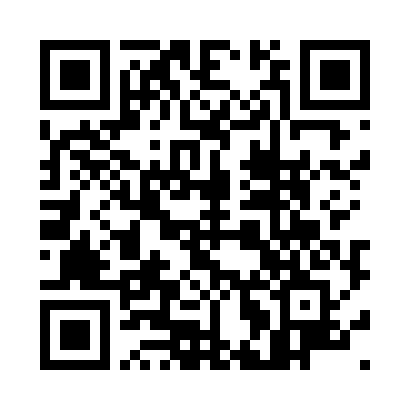

In [5]:
!python -m pip install --upgrade qrcode
import qrcode
qr = qrcode.make("https://github.com/hammal/IMSE2025/blob/main/tutorial.ipynb")
display(qr)

In [1]:
!python -m venv imse2025
!source imse2025/bin/activate
!python -m pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0

  Cloning https://github.com/hammal/cbadc.git (to revision feature/0.4.0) to /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-l49bahil
  Running command git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-l49bahil
  Running command git checkout -b feature/0.4.0 --track origin/feature/0.4.0
  Switched to a new branch 'feature/0.4.0'
  branch 'feature/0.4.0' set up to track 'origin/feature/0.4.0'.
  Resolved https://github.com/hammal/cbadc.git to commit a1b98e7f3d41c3ebcb39d7c5f1ad2bb5df5b8ccc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/hammal/python-deltasigma.git (to revision 2a79cc4dee79bbab45f6ceb783eea30c94f11c45) to /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-install-x8bkvjqg/deltasigma_f27e21f91abe4c8aadcc4a92e4b1c346
  Running comman